In [ ]:
using Pkg
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("QuadGK")
Pkg.add("SpecialFunctions")
Pkg.add("Optim")
Pkg.add("Printf")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/NMarkov.jl.git"))

In [2]:
using SparseArrays
using NMarkov
using Plots
using Distributions
using QuadGK
using SpecialFunctions
using Optim
using Printf
using DataFrames
using CSV
using SparseMatrix

In [3]:
import NMarkov.eye
function eye(M::AbstractMatrix)
    eye(size(M)[1])
end

eye (generic function with 3 methods)

## Zhao and Nakagawa

In [4]:
function GN(n, D0, D1)
    k = size(D0)[1]
    Qn = spzeros(AbstractMatrix{Float64}, n, n) # blockmatrix
    I = eye(D0)
    b = spzeros(AbstractMatrix{Float64}, n, 1)
    for i = 1:n
        Qn[i,i] = D0
    end
    for i = 1:n-1
        Qn[i,i+1] = D1
    end
    a = zeros(k, n*k)
    a[1:k,1:k] = I
    for i = 1:n
        b[i,1] = I
    end
    a, sparse(block(Qn)), Matrix(sparse(block(b)))
end

function gN(n, D0, D1)
    k = size(D0)[1]
    Qn = spzeros(AbstractMatrix{Float64}, n, n) # blockmatrix
    I = eye(D0)
    for i = 1:n
        Qn[i,i] = D0
    end
    for i = 1:n-1
        Qn[i,i+1] = D1
    end
    a = zeros(k, n*k)
    a[1:k,1:k] = I
    b = zeros(n*k, k)
    b[((n-1)*k)+1:(n*k),1:k] = D1
    a, sparse(block(Qn)), b
end

function g2N(n, D0, D1)
    k = size(D0)[1]
    Qn = spzeros(AbstractMatrix{Float64}, n+1, n+1) # blockmatrix
    I = eye(D0)
    for i = 1:n
        Qn[i,i] = D0
    end
    for i = 1:n
        Qn[i,i+1] = D1
    end
    Qn[n+1,n+1] = D0 + D1
    a = zeros(k, (n+1)*k)
    a[1:k,1:k] = I
    b = zeros((n+1)*k, k)
    b[(n*k)+1:((n+1)*k),1:k] = I
    a, sparse(block(Qn)), b
end

g2N (generic function with 1 method)

In [5]:
function PfProb(t0, n, D0, D1, dist)
    Q = D0 + D1
    I = eye(D0)
    p0 = mexpmix(Q, I, bounds = (0.0, t0), rmax = 10000) do t
        pdf(dist, t)
    end

    a, A, b = g2N(n, D0, D1)
    p1 = ccdf(dist, t0) * a * mexp(A, b, t0, rmax = 10000)

    a, A, b = GN(n, D0, D1)
    bdash = mexp(A, b, t0, rmax = 10000)
    p2 = a * mexpmix(A, bdash, bounds = (0.0, Inf64), rmax = 10000) do t
        pdf(dist, t + t0)
    end

    a, A, b = gN(n, D0, D1)
    bdash = mexp(A, b, t0, rmax = 10000)
    _, tmp = mexpcmix(A, bdash, bounds = (0.0, Inf64), rmax = 10000) do t
        pdf(dist, t + t0)
    end
    p3 = a * tmp
    
    P = p0 + p1 + p2 + p3
    gth(P)
end

PfProb (generic function with 1 method)

In [6]:
function gbar(t, n, pss, D0, D1)
    a, A, b = GN(n, D0, D1)
    sum((a * exp(Matrix(A)*t) * b)' * pss)
end

gbar (generic function with 1 method)

In [7]:
function T(t0, dist)
    res = quadgk(x -> ccdf(dist, x), 0, t0, rtol=1e-8)
    res[1]
end

T (generic function with 1 method)

In [8]:
function C(t0, dist, cp, cf)
    cp + (cf - cp)*cdf(dist, t0)
end

C (generic function with 1 method)

In [9]:
# standard age replacement
As(t0, dist, cp, cf) = C(t0, dist, cp, cf) / T(t0, dist)

As (generic function with 1 method)

In [10]:
function Top(t0, n, dist, pss, D0, D1)
    t1 = quadgk(x -> ccdf(dist, x), 0, t0, rtol=1e-8)
    a, A, b = GN(n, D0, D1)
    bdash = mexp(A, b, t0, rmax = 10000)
    tmp = mexpmix(A, bdash, bounds = (0.0, Inf64), rmax = 10000) do t
        ccdf(dist, t + t0)
    end
    t2 = sum((a * tmp)' * pss)
    t1[1] + t2
end

Top (generic function with 1 method)

In [11]:
function Cop(t0, n, dist, co, cp, cf, pss, D0, D1)
    a, A, b = GN(n, D0, D1)
    tmp = mexp(A, b, t0, rmax = 10000)
    t1 = sum((a * tmp)' * pss)
    a, A, b = gN(n, D0, D1)
    bdash = mexp(A, b, t0, rmax = 10000)
    tmp = mexpmix(A, bdash, bounds = (0.0, Inf64), rmax = 10000) do t
        ccdf(dist, t + t0)
    end
    t2 = sum((a * tmp)' * pss)
    cf - (cf - cp) * ccdf(dist, t0) * (1-t1) - (cf - co) * t2
end

Cop (generic function with 1 method)

In [12]:
# opportunity
function Aop(t0, n, dist, co, cp, cf, D0, D1)
    if n != 0
        pss = PfProb(t0, n, D0, D1, dist)
        Cop(t0, n, dist, co, cp, cf, pss, D0, D1) / Top(t0, n, dist, pss, D0, D1)
    else
        As(t0, dist, cp, cf)
    end
end

Aop (generic function with 1 method)

In [13]:
# opportunity
function Aop2(t0, n, dist, co, cp, cf, init, D0, D1)
    if n != 0
        Cop(t0, n, dist, co, cp, cf, init, D0, D1) / Top(t0, n, dist, init, D0, D1)
    else
        As(t0, dist, cp, cf)
    end
end

Aop2 (generic function with 1 method)

In [14]:
function failure_param(;mttf, cv)
    m = optimize(m -> (gamma(1+2/m)/gamma(1+1/m)^2 - 1.0 - cv^2)^2, 0.0001, 10.0).minimizer
    eta = mttf / gamma(1+1/m)
    dist = Weibull(m, eta)

    println("failure shape parameter ", m)
    println("failure scale parameter ", eta)
    println("failure mttf ", mttf)
    println("failure cv ", cv)
    return dist
end

failure_param (generic function with 1 method)

In [15]:
function poisson_param(;mttop)
    # poisson
    D0 = Float64[-2 1; 1 -2]
    D1 = Float64[1 0; 0 1]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)

    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", sqrt(mo2 - mo^2)/mo)
    return D0, D1, 1.0
end

function hyporenewal_param(;mttop, b)
    # hypo renewal
#     b = Float64[1, 1]
    D0 = Float64[-b[1] b[1]; 0 -b[2]]
    D1 = Float64[0 0; b[2] 0]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)
    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv
end

function hyperrenewal_param(;mttop, u, b)
    # hyper exp
    D0 = Float64[-b[1] 0; 0 -b[2]]
    D1 = reshape(b, 2, 1) * reshape(u, 1, 2)

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)
    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv

end

function mmpp_param(;mttop, u, b)
    # mmpp
    D0 = Float64[-(u[1]+b[1]) u[1]; u[2] -(u[2]+b[2])]
    D1 = Float64[b[1] 0; 0 b[2]]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)

    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv
end

mmpp_param (generic function with 1 method)

In [16]:
function optim(;maxn = 30, mint=1.0, maxt=20.0, dist, co, cp, cf, D0, D1)
    minvalue = 1.0
    local minresult, minn
    for n = 0:maxn
        result = optimize(x -> Aop(x, n, dist, co, cp, cf, D0, D1), mint, maxt)
        if result.minimum <= minvalue
            minvalue = result.minimum
            minresult = result
            minn = n
        end
    end
    minn, minresult
end

optim (generic function with 1 method)

In [17]:
function optim2(;maxn = 30, mint=1.0, maxt=20.0, dist, co, cp, cf, init, D0, D1)
    minvalue = 1.0
    local minresult, minn
    for n = 0:maxn
        result = optimize(x -> Aop2(x, n, dist, co, cp, cf, init, D0, D1), mint, maxt)
        if result.minimum <= minvalue
            minvalue = result.minimum
            minresult = result
            minn = n
        end
    end
    if isapprox(minresult.minimizer, 1.0, atol=1e-3)
        n, res = optim2(mint=1e-5, maxt=10.0, dist=dist, co=co, cp=cp, cf=cf, init=init, D0=D0, D1=D1)
        if res.minimum < minresult.minimum
            n, res
        else
            minn, minresult
        end
    else
        minn, minresult
    end
end

optim2 (generic function with 1 method)

In [18]:
co, cp, cf = 1.0, 1.0, 10.0
mttf = 10.0
dist = failure_param(mttf = mttf, cv = 0.1)
D0, D1 = hyporenewal_param(mttop = 1.0, b=[1,2])

failure shape parameter 9.999999703209413
failure scale parameter 10.511370074337558
failure mttf 10.0
failure cv 0.1
mean opportunity interval 1.0
cv for opportunity interval 0.9147320339189785


([-1.16667 1.16667; 0.0 -2.33333], [0.0 0.0; 2.33333 0.0], 0.9147320339189785)

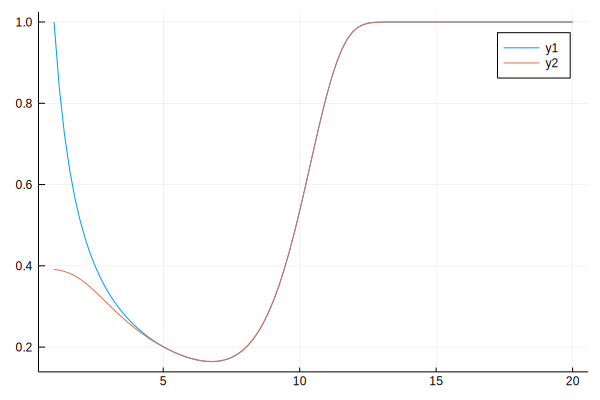

In [19]:
ts = LinRange(1, 20.0, 100)
value = [As(t0, dist, cp, cf) for t0 = ts]
value1 = [Aop(t0, 2, dist, co, cp, cf, D0, D1) for t0 = ts];
plot(ts, value)
plot!(ts, value1)

In [ ]:
cp = 1.0
cf = 10.0
mttf = 10.0
result = []
for cv in [0.1, 0.5, 0.8]
    println("cv ", cv)
    mttop = 0
    ocv = 0
    dist = failure_param(mttf = mttf, cv = cv)
    result0 = optimize(t0 -> As(t0, dist, cp, cf), 1, mttf*2)
    push!(result, ("st", cp, cv, mttop, ocv, 0, result0.minimizer, result0.minimum, result0.converged))
    for co in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        println("co ", co)
        for mttop in [0.1, 1.0, 2.0, 5.0, 10.0]
            println("mttop ", mttop)
            D0, D1, ocv = poisson_param(mttop = mttop)
            opn, result1 = optim(dist=dist, co=co, cp=cp, cf=cf, D0=D0, D1=D1)
            push!(result, ("poi", co, cv, mttop, ocv, opn, result1.minimizer, result1.minimum, result1.converged))
            for b in [[1, 5], [1, 2], [1, 1]]
                D0, D1, ocv = hyporenewal_param(mttop = mttop, b=b)
                opn, result1 = optim(dist=dist, co=co, cp=cp, cf=cf, D0=D0, D1=D1)
                push!(result, ("hypo", co, cv, mttop, ocv, opn, result1.minimizer, result1.minimum, result1.converged))
            end
            b = [10, 1]
            for u in [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
                D0, D1, ocv = hyperrenewal_param(mttop = mttop, u=u, b=b)
                opn, result1 = optim(dist=dist, co=co, cp=cp, cf=cf, D0=D0, D1=D1)
                push!(result, ("hyper", co, cv, mttop, ocv, opn, result1.minimizer, result1.minimum, result1.converged))
            end
            u = [1, 1]
            for b in [[1, 2], [1, 5], [1, 10]]
                D0, D1, ocv = mmpp_param(mttop = mttop, u=u, b=b)
                opn, result1 = optim(dist=dist, co=co, cp=cp, cf=cf, D0=D0, D1=D1)
                push!(result, ("mmpp", co, cv, mttop, ocv, opn, result1.minimizer, result1.minimum, result1.converged))
            end
        end
    end
end
result = DataFrame(result)
@show result
result |> CSV.write("rl.csv", delim=',', header=false)

In [ ]:
cp = 1.0
cf = 10.0
mttf = 10.0
result = []
for cv in [0.1] # [0.1, 0.5, 0.8]
    println("cv ", cv)
    mttop = 0
    ocv = 0
    dist = failure_param(mttf = mttf, cv = cv)
#     result0 = optimize(t0 -> As(t0, dist, cp, cf), 1, mttf*2)
#     push!(result, ("st", cp, cv, mttop, ocv, 0, result0.minimizer, result0.minimum, result0.converged))
    for co in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        println("co ", co)
        for mttop in [1.0] # [0.1, 1.0, 2.0, 5.0, 10.0]
            println("mttop ", mttop)
#             D0, D1, ocv = poisson_param(mttop = mttop)
#             opn, result1 = optim(dist=dist, co=co, cp=cp, cf=cf, D0=D0, D1=D1)
#             push!(result, ("poi", co, cv, mttop, ocv, opn, result1.minimizer, result1.minimum, result1.converged))
            for b in [[1, 1], [1, 2]] # [[1, 5], [1, 2], [1, 1]]
                D0, D1, ocv = hyporenewal_param(mttop = mttop, b=b)
                init = Float64[1,0]
                opn, result1 = optim2(dist=dist, co=co, cp=cp, cf=cf, init=init, D0=D0, D1=D1)
                push!(result, ("hypo", co, cv, mttop, ocv, opn, result1.minimizer, result1.minimum, result1.converged))
            end
            b = [10, 1]
            for u in [[0.5, 0.5], [0.8, 0.2]] # [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
                D0, D1, ocv = hyperrenewal_param(mttop = mttop, u=u, b=b)
                init = u
                opn, result1 = optim2(dist=dist, co=co, cp=cp, cf=cf, init=init, D0=D0, D1=D1)
                push!(result, ("hyper", co, cv, mttop, ocv, opn, result1.minimizer, result1.minimum, result1.converged))
            end
#             u = [1, 1]
#             for b in [[1, 2], [1, 5], [1, 10]]
#                 D0, D1, ocv = mmpp_param(mttop = mttop, u=u, b=b)
#                 init = Float64[0.5,0.5]
#                 opn, result1 = optim2(dist=dist, co=co, cp=cp, cf=cf, init=init, D0=D0, D1=D1)
#                 push!(result, ("mmpp", co, cv, mttop, ocv, opn, result1.minimizer, result1.minimum, result1.converged))
#             end
        end
    end
end
result = DataFrame(result)
@show result
result |> CSV.write("rl2.csv", delim=',', header=false)

In [20]:
cp = 1.0
cf = 1.2
co = 0.8
mttf = 10.0
cv = 0.5
mttop = 1.0
dist = failure_param(mttf = mttf, cv = cv)
# D0, D1, ocv = poisson_param(mttop = mttop)
# D0, D1, ocv = hyporenewal_param(mttop = mttop, b=[1,5]) # [[1, 5], [1, 2], [1, 1]]
# D0, D1, ocv = mmpp_param(mttop = mttop, u=[1,1], b=[1,10]) # u=[1,1] b=[[1, 2], [1, 5], [1, 10]]
D0, D1, ocv = hyperrenewal_param(mttop = mttop, u=[0.2,0.8], b=[10,1]) # b = [10, 1], u = [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
opn, result1 = optim(dist=dist, co=co, cp=cp, cf=cf, D0=D0, D1=D1, maxn=10, maxt=20.0)
println(opn, result1)

failure shape parameter 2.1013490844203857
failure scale parameter 11.290633895036326
failure mttf 10.0
failure cv 0.5
mean opportunity interval 1.0
cv for opportunity interval 1.0199501246882794
10Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [1.000000, 20.000000]
 * Minimizer: 2.000000e+01
 * Minimum: 1.203776e-01
 * Iterations: 36
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 37


In [90]:
opn, result1 = optim(dist=dist, co=co, cp=cp, cf=cf, D0=D0, D1=D1, maxn=10, maxt=10.0, mint=1e-5)
println(opn, result1)

4Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000010, 10.000000]
 * Minimizer: 3.468632e-03
 * Minimum: 4.736311e-01
 * Iterations: 40
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 41


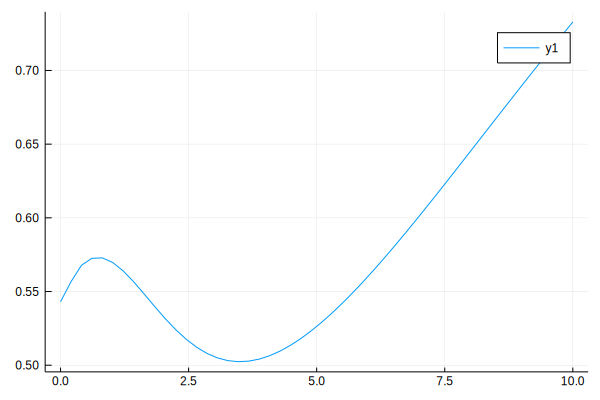

In [93]:
ts = LinRange(1e-5, 10.0, 50)
val = [Aop(t0, 2, dist, co, cp, cf, D0, D1) for t0 = ts]
plot(ts, val)
# Aop(20.0, 5, dist, co, cp, cf, D0, D1)

In [114]:
for co in [0.5, 0.6, 0.7, 0.8, 0.9]
    cp = 1.0
cf = 10.0
mttf = 10.0
cv = 0.8
mttop = 5.0
dist = failure_param(mttf = mttf, cv = cv)
D0, D1, ocv = poisson_param(mttop = mttop)
# D0, D1, ocv = hyporenewal_param(mttop = mttop, b=[1,2]) # [[1, 5], [1, 2], [1, 1]]
# D0, D1, ocv = mmpp_param(mttop = mttop, u=[1,1], b=[1,10]) # u=[1,1] b=[[1, 2], [1, 5], [1, 10]]
# D0, D1, ocv = hyperrenewal_param(mttop = mttop, u=[0.8,0.2], b=[10,1]) # b = [10, 1], u = [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
opn, result1 = optim(dist=dist, co=co, cp=cp, cf=cf, D0=D0, D1=D1, maxn=20, maxt=10.0, mint=1.0e-5)
println(opn, result1)
end

failure shape parameter 1.2582492600566424
failure scale parameter 10.752664365753148
failure mttf 10.0
failure cv 0.8
mean opportunity interval 5.0
cv for opportunity interval 0.9999999999999998
1Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000010, 10.000000]
 * Minimizer: 4.123225e+00
 * Minimum: 9.002825e-01
 * Iterations: 16
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 17
failure shape parameter 1.2582492600566424
failure scale parameter 10.752664365753148
failure mttf 10.0
failure cv 0.8
mean opportunity interval 5.0
cv for opportunity interval 0.9999999999999998
0Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000010, 10.000000]
 * Minimizer: 5.957211e+00
 * Minimum: 9.041888e-01
 * Iterations: 18
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 19
failure shape parameter 1.